# Imports

In [1]:
# import the required libraries
import numpy as np
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

import time
import random
import  cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

In [2]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

!pip install -qU svgwrite
import svgwrite # conda install -c omnia svgwrite=1.1.6


     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


In [4]:
!pip install -q magenta


     |████████████████████████████████| 512kB 2.7MB/s 


In [5]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

W1205 11:25:19.695929 140259815909248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/music/note_sequence_io.py:60: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W1205 11:25:19.715667 140259815909248 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1205 11:25:21.609268 140259815909248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:35: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W1205 11:25:21.610960 140259815909248 module_wrapper.py:139] From /usr/local/lib/

In [0]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.05, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

Paths

In [0]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'

In [8]:
download_pretrained_models(models_root_dir=models_root_dir)


W1205 11:25:30.623168 140259815909248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:98: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

I1205 11:25:30.626854 140259815909248 sketch_rnn_train.py:105] Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
I1205 11:25:39.576687 140259815909248 sketch_rnn_train.py:107] Download complete.
I1205 11:25:39.581824 140259815909248 sketch_rnn_train.py:108] Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
I1205 11:25:41.739905 140259815909248 sketch_rnn_train.py:111] Unzipping complete.


In [0]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [12]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

I1205 11:27:07.066061 140259815909248 sketch_rnn_train.py:133] Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
I1205 11:27:09.948067 140259815909248 sketch_rnn_train.py:143] Loaded 7400/300/300 from aaron_sheep.npz
I1205 11:27:10.329495 140259815909248 sketch_rnn_train.py:160] Dataset combined: 8000 (7400/300/300), avg len 125
I1205 11:27:10.336760 140259815909248 sketch_rnn_train.py:167] model_params.max_seq_len 250.


total images <= max_seq_len is 7400


I1205 11:27:11.235851 140259815909248 sketch_rnn_train.py:210] normalizing_scale_factor 18.5198.


total images <= max_seq_len is 300
total images <= max_seq_len is 300


In [14]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

I1205 11:28:00.480937 140259815909248 model.py:87] Model using gpu.
I1205 11:28:00.490211 140259815909248 model.py:175] Input dropout mode = False.
I1205 11:28:00.493602 140259815909248 model.py:176] Output dropout mode = False.
I1205 11:28:00.495465 140259815909248 model.py:177] Recurrent dropout mode = True.
I1205 11:28:04.084726 140259815909248 model.py:87] Model using gpu.
I1205 11:28:04.087048 140259815909248 model.py:175] Input dropout mode = 0.
I1205 11:28:04.088798 140259815909248 model.py:176] Output dropout mode = 0.
I1205 11:28:04.090012 140259815909248 model.py:177] Recurrent dropout mode = 0.
I1205 11:28:04.501352 140259815909248 model.py:87] Model using gpu.
I1205 11:28:04.503032 140259815909248 model.py:175] Input dropout mode = 0.
I1205 11:28:04.508733 140259815909248 model.py:176] Output dropout mode = 0.
I1205 11:28:04.510029 140259815909248 model.py:177] Recurrent dropout mode = 0.


In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [16]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

W1205 11:28:08.316930 140259815909248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:240: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W1205 11:28:08.318443 140259815909248 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:240: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

I1205 11:28:08.407704 140259815909248 sketch_rnn_train.py:242] Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
I1205 11:28:08.412688 140259815909248 saver.py:1284] Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

Strokes object variable is the list of data points, which are sequences of strokes, represented as a 2D NumPy array of xy-offsets and the pen state



In [0]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist() # Converts from stroke-3 to stroke-5 format and pads to given length.
  strokes.insert(0, [0, 0, 1, 0, 0]) # insert special start token
  seq_len = [len(input_strokes)] 
  draw_strokes(to_normal_strokes(np.array(strokes))) # Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3.
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.05):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [0]:
# get a sample drawing from the test set, and render it to .svg
#...

Let's try to encode the sample stroke into latent vector $z$



In [0]:
#...

convert z back to drawing at temperature of 0.8


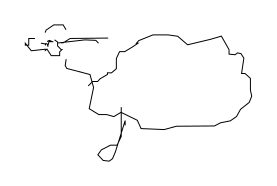

In [36]:
# ...

Create generated grid at various temperatures from 0.1 to 1.0



In [0]:
stroke_list = []
#...

# Latent space Interpolation between $z_0$ and $z_1$

In [0]:
# get a sample drawing from the test set, and render it to .svg
#...

In [0]:
#...

Now we interpolate between sheep $z_0$ and sheep $z_1$



In [0]:
#...

In [0]:
# for every latent vector in z_list, sample a vector image
#...

In [0]:
#...

# Unconditional Generation

We'll load the Flamingo model and try decoder-only generation

In [0]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'


In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)


In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
# randomly unconditionally generate 10 examples
#...

In [0]:
#...

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors



In [0]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'


In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = #...

In [0]:
z_1 = #...


Let's interpolate between the two owls $z_0$ and $z_1$



In [0]:
#....

In [0]:
#...

Let's load the model trained on both cats and buses! catbus!



In [0]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'


In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_1 = #....

In [0]:
z_0 = #...

In [0]:
z_list = [] # interpolate spherically between z_1 and z_0
#....
#....
#....


In [0]:
#....


Why stop here? Let's load the model trained on both elephants and pigs!!!



In [0]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = #....


In [0]:
z_1 = #....


Tribute to an episode of South Park: The interpolation between an Elephant and a Pig



In [0]:
z_list = [] # interpolate spherically between z_1 and z_0


In [0]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)


In [0]:
draw_strokes(stroke_grid, factor=0.05)
